# Training a neural network on MNIST with Keras&Tensorflow



In this Notebook you will start playing with the "Hello World" of Nueral Networks: The MNIST Dataset. And we will expand from there.

### 1. Classification of hand-written digits

In [ ]:
# Neue Imports tfds und callbacks und os und time für tensorboard

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import os
import time



In [34]:
root_logdir = os.path.join(os.curdir, "my_logs_emnist")

def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

In [35]:
tensorboard_cb = TensorBoard(log_dir=run_logdir)

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/letters',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True, 
)

def prepare_dataset(dataset):
    images = []
    labels = []
    for image, label in dataset:
        images.append(image.numpy())
        labels.append(label.numpy() - 1)
    return np.array(images), np.array(labels)

train_images, train_labels = prepare_dataset(ds_train)
test_images, test_labels = prepare_dataset(ds_test)

train_images = train_images / 255.0
test_images = test_images / 255.0

letters = [chr(ord('A') + i) for i in range(26)]

print('Training set shape:', train_images.shape)
print('Test set shape:', test_images.shape)

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...: 100%|██████████| 1/1 [00:18<00:00, 14.19s/ url]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]2025-05-05 11:54:00.809660: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-05-05 11:54:23.608798: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


Dataset emnist downloaded and prepared to /home/codespace/tensorflow_datasets/emnist/letters/3.1.0. Subsequent calls will reuse this data.


2025-05-05 11:54:40.738480: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-05 11:54:43.674474: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training set shape: (88800, 28, 28, 1)
Test set shape: (14800, 28, 28, 1)


In [6]:
# ANPASSSSSSSSSSSSSSSSUNG
#
# In x_valid werden die ersten 5000 Bilder als Validierungsdatensatz gespeichert und in x Train die restlichen ab Bild 5000
X_valid, X_train = train_images[:5000], train_images[5000:]
y_valid, y_train = train_labels[:5000], train_labels[5000:]

In [28]:
early_stop = EarlyStopping(
    monitor="val_loss",          # beobachte den Validierungsfehler
    patience=3,                  # warte 3 Epochen ohne Verbesserung
    restore_best_weights=True    # stell das beste Modell wieder her
)

checkpoint_cb = ModelCheckpoint(
    "best_emnist_model.h5",   # Dateiname zum Speichern
    save_best_only=True       # Nur speichern, wenn val_loss sich verbessert
)


### Create and train the model
Implement an ANN with 2 Hidden Layers, the first with 128 neurons and "relu" activation functions. The second layers instead contains 64 neurons (also relu activation function).
Don't forget the output layer :)

Also, remember that due to the 2D structure of your input data you need to first flatten them. Use the following specific layer at the very beginning inside your Sequential Model:


tf.keras.layers.Flatten(input_shape=(28, 28))

Notabene: you don't need to provide the input_dim in the first Dense layer, if you start with a Flatten layer.

In [36]:
# GEÄNDERTTTTTTTTTT2222222222222222222
# In relu Schicht die Erweiterung mit der L2 Regularisierung hinzugefügt. Diese bestraft zu hohe Gewichtswerte und hilft so Overfitting zu vermeiden. 
# 0.01 = Eher starke Bestrafung für bei viel Overfitting. 0.1 wäre extrem. 0.001 oft Standardwahl.
# Dropout Layer eingefügt. Der macht dass in der Dense Relu Schicht darunter bei 0.3 also 30% der Neuronen im Training zufällig abgeschaltet werden.
# Bei kleinen Netzen 0.2. Standard 0.3. Bei sehr grossen Netzen 0.5.

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
  tf.keras.layers.Dense(128, activation="relu", kernel_regularizer = tf.keras.regularizers.L2(0.01)), 
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(64, activation="relu", kernel_regularizer = tf.keras.regularizers.L2(0.01)), 
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(26, activation="softmax")
])

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Since my input are 2D images, I need first to "flatten" them into a 1-dimensional array. The number of input neurons will be the total number of pixels.

Define now which cost function to minimize in the .compile method. Take "sgd" as optimizer and track the accuracy as metric.

For classification:Pay attention to the last layer if sigmoid or softmax is explicitly indicated, then from_logits = False

Notabene: Here a Sparse Categorical Crossentropy is used, becuase we are dealing with a multi-class classification If it would be a binary classification, then the loss function (i.e. the cost function) would have been Binary Crossentropy

For a full lists of cost functions available in tf.keras (both for Regression and Classification) https://www.tensorflow.org/api_docs/python/tf/keras/losses

In [37]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [38]:
# Callbacks hinzugefügt die auf Basis der weiter oben definierten Funktionen (zb early_stop) funktionieren

history = model.fit(X_train, y_train, epochs=15,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stop, checkpoint_cb, tensorboard_cb])

Epoch 1/15
2619/2619 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.4541 - loss: 2.6929 - val_accuracy: 0.7186 - val_loss: 1.4262
Epoch 2/15
2619/2619 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6311 - loss: 1.6557 - val_accuracy: 0.7432 - val_loss: 1.3206
Epoch 3/15
2619/2619 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6593 - loss: 1.5352 - val_accuracy: 0.7656 - val_loss: 1.2116
Epoch 4/15
2619/2619 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6789 - loss: 1.4626 - val_accuracy: 0.7742 - val_loss: 1.1736
Epoch 5/15
2619/2619 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6893 - loss: 1.4243 - val_accuracy: 0.7780 - val_loss: 1.1337
Epoch 6/15
2619/2619 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6936 - loss: 1.4023 - val_accuracy: 0.7878 - val_loss: 1.0935
Epoch 7/15
2619/2619 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7023 - loss: 1.3680 - val_accuracy: 0.7924 - val_loss: 1.0843
Epoch 8/15
2619/2619 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7005 - loss: 1.3675 - 

In [39]:
model.evaluate(test_images, test_labels)

463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7750 - loss: 1.0838


[1.0870938301086426, 0.7766216397285461]

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=my_logs_emnist --port=6006

# Alternatives Vorgehen Dozent
# Manuelles Logging (zb Bilder, Text, eigene Werte), bei mir werden bei jedem Trainingsdurchlauf automatisch Loss, Accuracy etc gespeichert
# Dozent loggt hier zb beispielbilder aus emnist in Tensorboard als visuelle Kontrolle

#%load_ext tensorboard
#%tensorboard --logdir my_logs_ML2

#test_logdir = get_run_logdir()
#img = np.reshape(train_images[0:20], (-1, 28, 28, 1))
#writer = tf.summary.create_file_writer(test_logdir)
#with writer.as_default():

#    tf.summary.image('my_images', img, step=0)

#model.save("best_model_emnist.keras")

Let's now predict the digits for the first 3 images in the test set. Feel free to check more cases.
First we predict the score associated which every category and then we find out which one is the one with highest score.

### Experimental test

The final test consist in a "physical" test.
1) Draw on a piece of paper 1 single digit between 0 and 9.
2) Take a picture with your webcam of it
3) Test if the neural network can correctly identify also your handwriting


To do that you need to preprocess first your image and put it in the right format, by using the Keras function 'load_img'
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/load_img
ATTENTION: your image need to be resized in the same size that you used for training.... And pay attention to RGB images and grayscale!

Now you can simply predict the class of your image, as done just before for the MNIST test images.


Is the result correct?

### Plot the evolution of accuracy and loss
The historical values of accuracy and loss during training and validation are stored during training in the variable "history".
You can access them through history.history.
Use this information to plot and compare the evolution of accuracy and loss for training and validation. What can you learn from this?

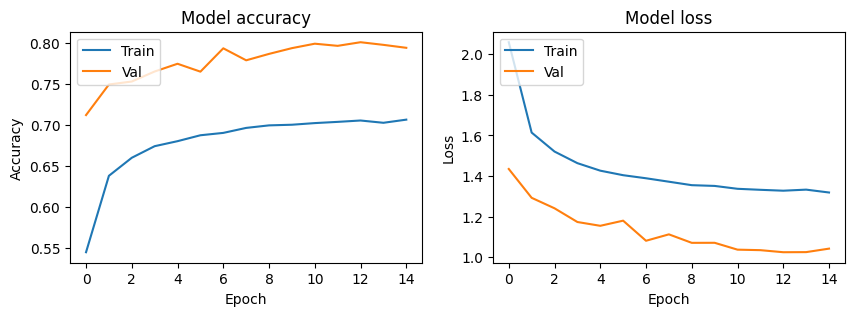

In [27]:
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()